## RNN for  Google Stock Price forecasting

### Import the necessary librariers

In [1]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.optimizers import Adam
import seaborn as sns
import plotly.io as pio
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense
from keras.callbacks import EarlyStopping



### Load the data & preprocess it

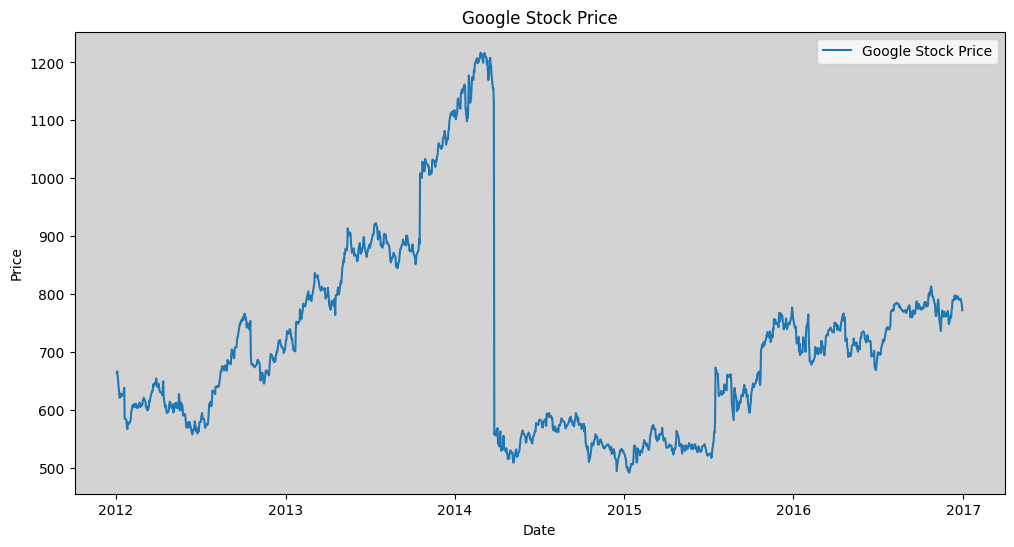

In [5]:
# Load the dataset
df = pd.read_csv('Google_Stock_Price_Train.csv')
df.head()
# Clean data: Remove commas and convert to float for 'Close' column
df['Close'] = df['Close'].replace({',': ''}, regex=True).astype(float)

# Convert 'Date' to datetime and set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot the closing price to understand the trend
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Google Stock Price')
plt.title('Google Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gca().set_facecolor('lightgrey')
plt.show()


### Data splitting

In [55]:
# Set train-test split ratio, validation split from training data
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

# Further split the training data into training and validation sets
val_size = int(len(train_data) * 0.1)  # 10% of training data for validation
train_data = train_data[:-val_size]
val_data = train_data[-val_size:]

# Extract 'Close' price and scale it
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Close']])
val_scaled = scaler.transform(val_data[['Close']])
test_scaled = scaler.transform(test_data[['Close']])


### Prepare Data for RNN Models:

We will use the past 30 days (N = 30) to predict the next day (M = 1)

In [56]:
# Create a dataset for RNN models
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # last 30 days as features
        y.append(data[i, 0])  # next day's price as target
    return np.array(X), np.array(y)

# Prepare training, validation, and test datasets
X_train, y_train = create_dataset(train_scaled)
X_val, y_val = create_dataset(val_scaled)
X_test, y_test = create_dataset(test_scaled)

# Reshape for RNN input (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


### Model Building:
We will implement three different models: Vanilla RNN, GRU, and LSTM.

Vanilla RNN

In [57]:
def build_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


GRU

In [58]:
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


LSTM

In [59]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


### Model Training

In [60]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Vanilla RNN Model
rnn_model = build_rnn_model()
history_rnn = rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                            callbacks=[early_stopping], verbose=1)

# Train the GRU Model
gru_model = build_gru_model()
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                            callbacks=[early_stopping], verbose=1)

# Train the LSTM Model
lstm_model = build_lstm_model()
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                              callbacks=[early_stopping], verbose=1)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0214 - val_loss: 0.0032
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0069 - val_loss: 0.0026
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 9.4573e-04
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 9.0549e-04
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - val_loss: 8.3602e-04
Epoch 10/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 7.4907e-04
Epoch 11/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 7.0678e-04
Epoch 12/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Predictions and Evaluation:

In [61]:
# Make predictions
train_pred_rnn = rnn_model.predict(X_train)
val_pred_rnn = rnn_model.predict(X_val)
test_pred_rnn = rnn_model.predict(X_test)

train_pred_gru = gru_model.predict(X_train)
val_pred_gru = gru_model.predict(X_val)
test_pred_gru = gru_model.predict(X_test)

train_pred_lstm = lstm_model.predict(X_train)
val_pred_lstm = lstm_model.predict(X_val)
test_pred_lstm = lstm_model.predict(X_test)

# Inverse scaling to get the original values
train_pred_rnn = scaler.inverse_transform(train_pred_rnn)
val_pred_rnn = scaler.inverse_transform(val_pred_rnn)
test_pred_rnn = scaler.inverse_transform(test_pred_rnn)

train_pred_gru = scaler.inverse_transform(train_pred_gru)
val_pred_gru = scaler.inverse_transform(val_pred_gru)
test_pred_gru = scaler.inverse_transform(test_pred_gru)

train_pred_lstm = scaler.inverse_transform(train_pred_lstm)
val_pred_lstm = scaler.inverse_transform(val_pred_lstm)
test_pred_lstm = scaler.inverse_transform(test_pred_lstm)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate the models
def evaluate_model(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    return rmse, r2, mae, mse

# Evaluation on the Test Set
metrics_rnn = evaluate_model(y_test_actual, test_pred_rnn)
metrics_gru = evaluate_model(y_test_actual, test_pred_gru)
metrics_lstm = evaluate_model(y_test_actual, test_pred_lstm)

# Display Evaluation Metrics
print("RNN Model Metrics - RMSE: {:.2f}, R²: {:.4f}, MAE: {:.2f}, MSE: {:.2f}".format(*metrics_rnn))
print("GRU Model Metrics - RMSE: {:.2f}, R²: {:.4f}, MAE: {:.2f}, MSE: {:.2f}".format(*metrics_gru))
print("LSTM Model Metrics - RMSE: {:.2f}, R²: {:.4f}, MAE: {:.2f}, MSE: {:.2f}".format(*metrics_lstm))


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
RNN Model Metrics - RMSE: 9.00, R²: 0.9282, MAE: 6.91, MSE: 80.94
GRU Model Metrics - RMSE: 14.50, R²: 0.8135, MAE: 10.71, MSE: 210.24
LSTM Model Metrics - RMSE: 16.29, R²: 0.7644, MAE: 12.24, MSE: 265.52


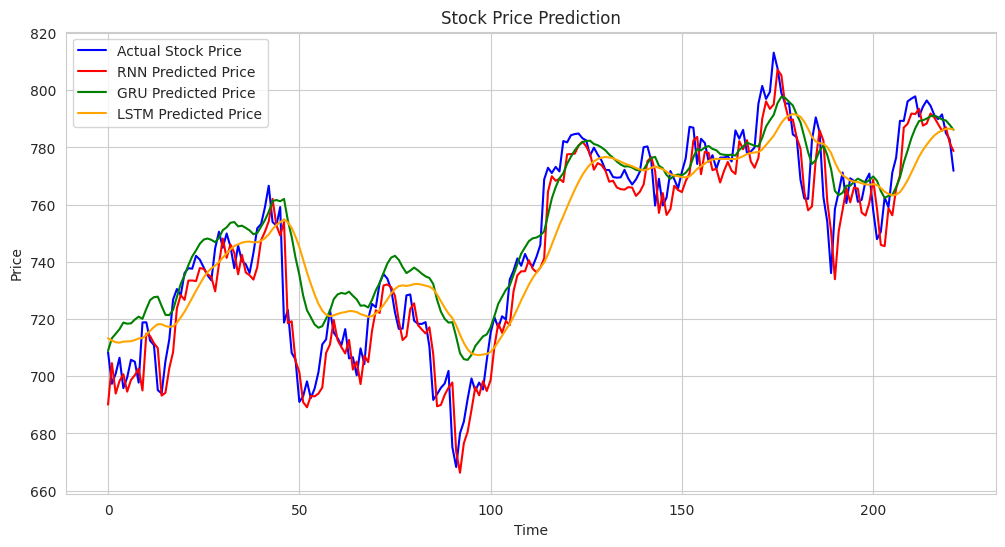

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Stock Price', color='blue')
plt.plot(test_pred_rnn, label='RNN Predicted Price', color='red')
plt.plot(test_pred_gru, label='GRU Predicted Price', color='green')
plt.plot(test_pred_lstm, label='LSTM Predicted Price', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv('Google_Stock_Price_Train.csv')
data = data[['Open']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create dataset with given sequence length
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Past sequence_length days as input
        y.append(data[i, 0])  # The next day's price as target
    return np.array(X), np.array(y)

# Split into train and test sets
train_size = int(len(data_scaled) * 0.8)
train_scaled = data_scaled[:train_size]
test_scaled = data_scaled[train_size:]

# Sequence lengths to experiment with
sequence_lengths = [7, 14, 30, 60]


In [64]:
# 1. Vanilla RNN Model
def build_vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 2. GRU Model
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 3. LSTM Model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [65]:
# Function to train and evaluate model for a given sequence length
def train_and_evaluate_model(model_func, sequence_length, train_scaled, test_scaled):
    # Create the dataset for the given sequence length
    X_train, y_train = create_dataset(train_scaled, sequence_length)
    X_test, y_test = create_dataset(test_scaled, sequence_length)

    # Reshape for RNN, GRU, and LSTM models
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the model
    model = model_func()

    # Train the model with early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Make predictions on test data
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and actual values
    y_pred = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    return rmse, y_test_actual, y_pred

# Initialize dictionaries to store results
results = {}

# Loop through sequence lengths and models
for sequence_length in sequence_lengths:
    results[sequence_length] = {}

    # Evaluate each model
    for model_func in [build_vanilla_rnn, build_gru_model, build_lstm_model]:
        model_name = model_func.__name__.split('_')[1].upper()  # Get model name (RNN, GRU, LSTM)
        rmse, y_test_actual, y_pred = train_and_evaluate_model(model_func, sequence_length, train_scaled, test_scaled)
        results[sequence_length][model_name] = {'RMSE': rmse, 'Actual': y_test_actual, 'Predicted': y_pred}

# Display Results
for sequence_length, models in results.items():
    print(f"Results for Sequence Length: {sequence_length} days")
    for model_name, result in models.items():
        print(f"{model_name} - RMSE: {result['RMSE']:.4f}")


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1347 - val_loss: 0.0198
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0129
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0140
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 0.0108
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0102
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0046
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3587e-04 - val_loss: 0.0025
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2559e-04 - val_loss: 0.0011
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2954

**Results for Sequence Length: 7 days**

VANILLA - RMSE: 11.9639
GRU - RMSE: 11.8141
LSTM - RMSE: 14.3577

**Results for Sequence Length: 14 days**

VANILLA - RMSE: 10.7551
GRU - RMSE: 10.2837
LSTM - RMSE: 14.1176

**Results for Sequence Length: 30 days**

VANILLA - RMSE: 8.5805
GRU - RMSE: 8.3770
LSTM - RMSE: 11.0235

**Results for Sequence Length: 60 days**
VANILLA - RMSE: 9.0085
GRU - RMSE: 8.6203
LSTM - RMSE: 12.4628

X_train shape: (1228, 30)
X_test shape: (1228, 30)
X_train reshaped: (1228, 30, 1)
X_test reshaped: (1228, 30, 1)
Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0313 - val_loss: 0.0031
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.9085e-04 - val_loss: 0.0013
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.2761e-04 - val_loss: 0.0012
Epoch 11/50
39/39 ━━━━━━━━━

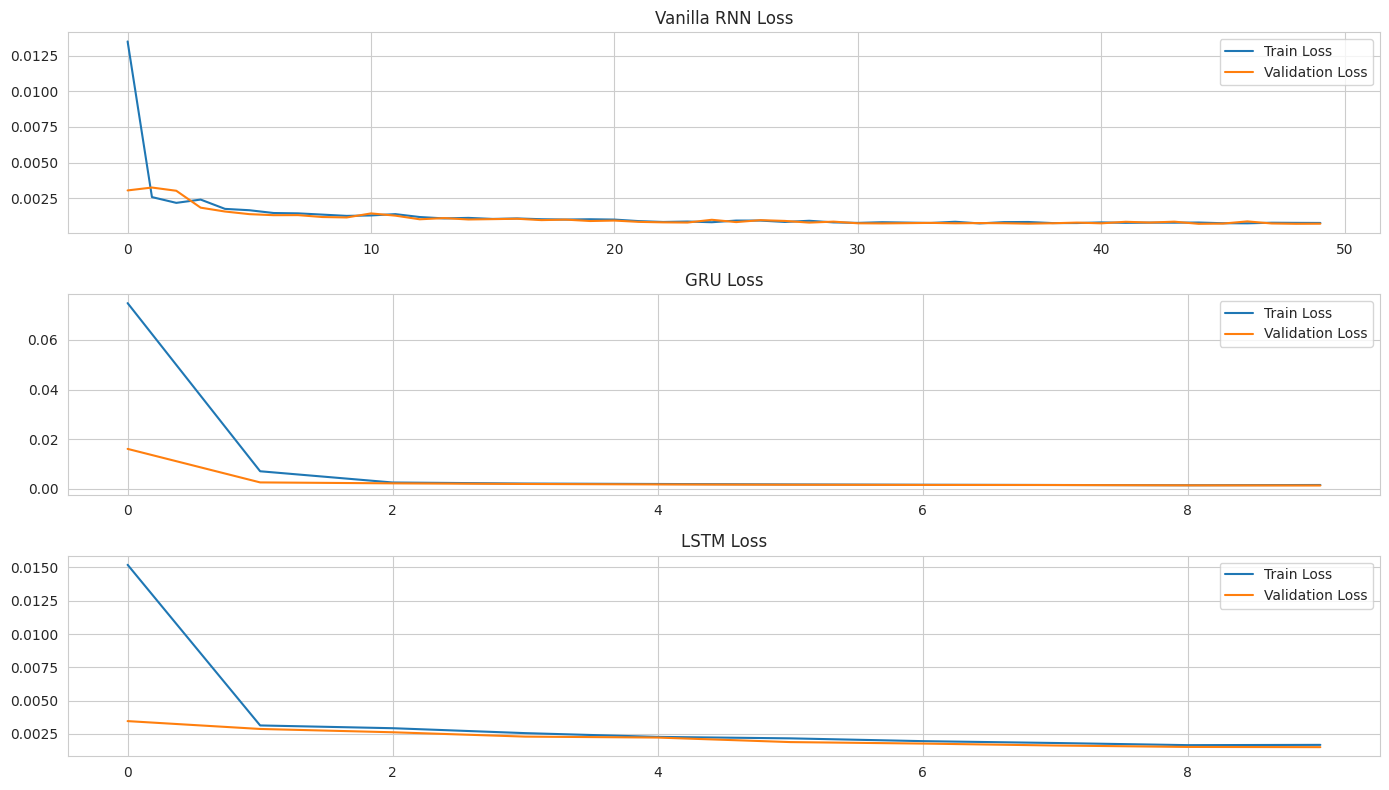

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


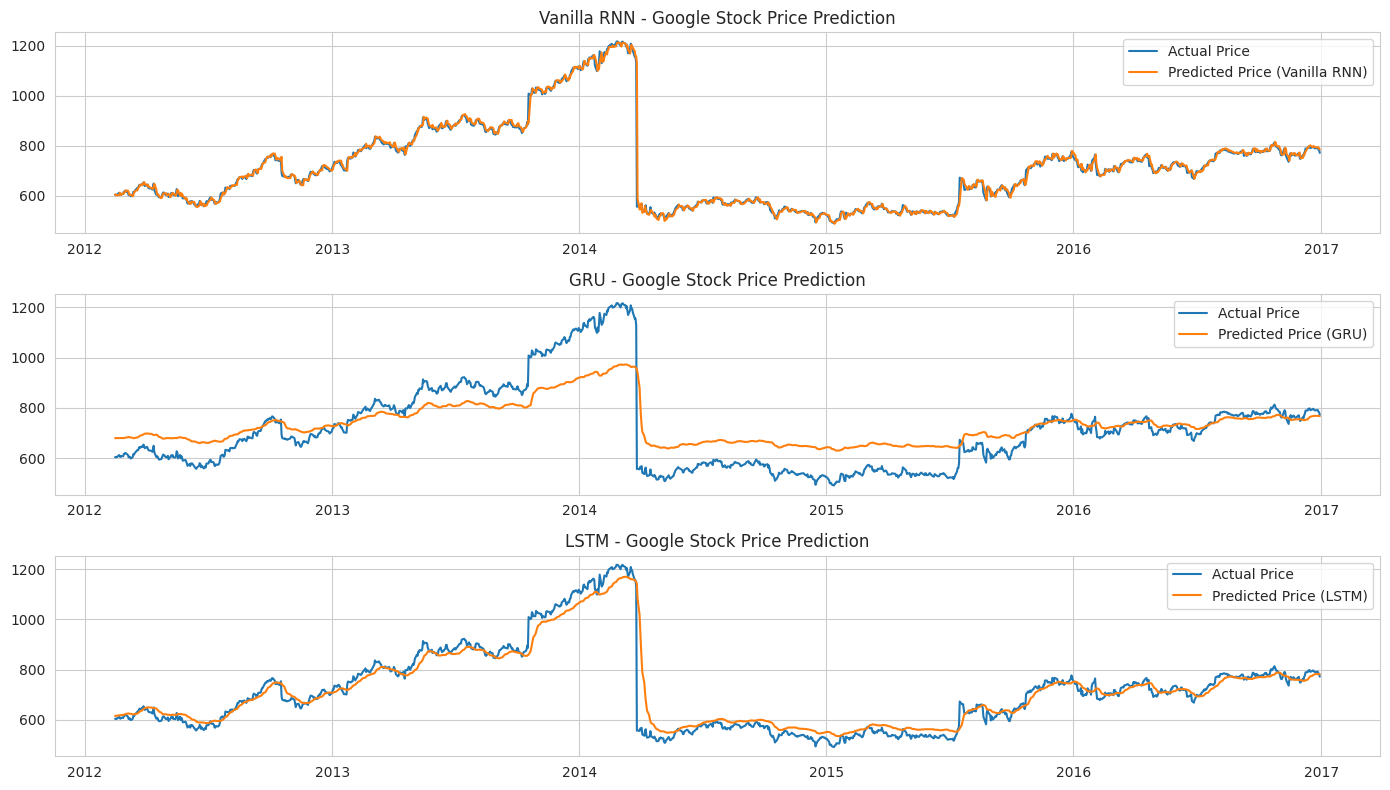

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, GRU, LSTM, Dense
from keras.callbacks import EarlyStopping

# Load the training and testing datasets
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Train.csv')

# Clean the 'Close' column by removing commas and converting to float
train_data['Close'] = train_data['Close'].replace({',': ''}, regex=True).astype(float)
test_data['Close'] = test_data['Close'].replace({',': ''}, regex=True).astype(float)

# Convert the Date column to datetime format and set it as the index
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Use the 'Close' price for prediction
train_prices = train_data[['Close']]
test_prices = test_data[['Close']]

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_prices = scaler.fit_transform(train_prices)
scaled_test_prices = scaler.transform(test_prices)

# Prepare the data for RNN models (using past 30 days data to predict the next day)
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # last 'time_step' days as features
        y.append(data[i, 0])  # the next day's price as the target
    return np.array(X), np.array(y)

time_step = 30
X_train, y_train = create_dataset(scaled_train_prices, time_step)
X_test, y_test = create_dataset(scaled_test_prices, time_step)

# Debugging: Check the shape of X_train and X_test
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Check if there are any issues with the dimensions of the dataset
if X_train.shape[1] == 0 or X_test.shape[1] == 0:
    raise ValueError("The feature dimension is zero, check the dataset size and time_step.")

# Reshape data for RNN models (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Debugging: Check the new shape after reshaping
print(f"X_train reshaped: {X_train.shape}")
print(f"X_test reshaped: {X_test.shape}")

# Define the early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 1. Vanilla RNN Model
def build_vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 2. GRU Model
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 3. LSTM Model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and evaluate the models

# Vanilla RNN
vanilla_rnn_model = build_vanilla_rnn()
history_vanilla_rnn = vanilla_rnn_model.fit(X_train, y_train, epochs=50, batch_size=32,
                                            validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# GRU
gru_model = build_gru_model()
history_gru = gru_model.fit(X_train, y_train, epochs=50, batch_size=32,
                            validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# LSTM
lstm_model = build_lstm_model()
history_lstm = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32,
                              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Plotting the training and validation loss
plt.figure(figsize=(14, 8))

# Vanilla RNN loss plot
plt.subplot(3, 1, 1)
plt.plot(history_vanilla_rnn.history['loss'], label='Train Loss')
plt.plot(history_vanilla_rnn.history['val_loss'], label='Validation Loss')
plt.title('Vanilla RNN Loss')
plt.legend()

# GRU loss plot
plt.subplot(3, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('GRU Loss')
plt.legend()

# LSTM loss plot
plt.subplot(3, 1, 3)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predicting the stock prices using each model

# Vanilla RNN predictions
predicted_rnn = vanilla_rnn_model.predict(X_test)
predicted_rnn = scaler.inverse_transform(predicted_rnn)

# GRU predictions
predicted_gru = gru_model.predict(X_test)
predicted_gru = scaler.inverse_transform(predicted_gru)

# LSTM predictions
predicted_lstm = lstm_model.predict(X_test)
predicted_lstm = scaler.inverse_transform(predicted_lstm)

# Plotting the results

plt.figure(figsize=(14, 8))

# Plotting actual vs predicted prices for Vanilla RNN
plt.subplot(3, 1, 1)
plt.plot(test_prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price')
plt.plot(test_prices.index[-len(y_test):], predicted_rnn, label='Predicted Price (Vanilla RNN)')
plt.title('Vanilla RNN - Google Stock Price Prediction')
plt.legend()

# Plotting actual vs predicted prices for GRU
plt.subplot(3, 1, 2)
plt.plot(test_prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price')
plt.plot(test_prices.index[-len(y_test):], predicted_gru, label='Predicted Price (GRU)')
plt.title('GRU - Google Stock Price Prediction')
plt.legend()

# Plotting actual vs predicted prices for LSTM
plt.subplot(3, 1, 3)
plt.plot(test_prices.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price')
plt.plot(test_prices.index[-len(y_test):], predicted_lstm, label='Predicted Price (LSTM)')
plt.title('LSTM - Google Stock Price Prediction')
plt.legend()

plt.tight_layout()
plt.show()


In [45]:
# Vanilla RNN model
def build_vanilla_rnn():
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))  # Output layer to predict the next day's price
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# GRU Model
def build_gru_model():
    model = Sequential()
    model.add(GRU(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

# LSTM Model
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(units=1))
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model


In [46]:
# Function to train and evaluate a model
def train_and_evaluate(model_func):
    model = model_func()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and actual values
    y_pred = scaler.inverse_transform(y_pred)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

    return rmse, y_test_actual, y_pred

# Evaluate each model
results = {}

for model_func in [build_vanilla_rnn, build_gru_model, build_lstm_model]:
    model_name = model_func.__name__.split('_')[1].upper()  # Get the model name (RNN, GRU, LSTM)
    rmse, y_test_actual, y_pred = train_and_evaluate(model_func)
    results[model_name] = {'RMSE': rmse, 'Actual': y_test_actual, 'Predicted': y_pred}

# Display Results
for model_name, result in results.items():
    print(f"{model_name} - RMSE: {result['RMSE']:.4f}")


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0153 - val_loss: 4.0898e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 3.2080e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 4.6179e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 2.2432e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 2.9311e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.6438e-04 - val_loss: 3.6313e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 1.9732e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1389e-04 - val_loss: 0.0011
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018 - val_loss: 1.8864e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.8104e-04 - val_loss: 2.7849e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 2.8852e-04
Epoch 12/50
32/32

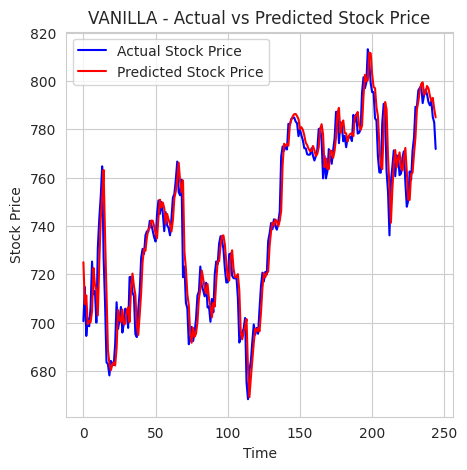

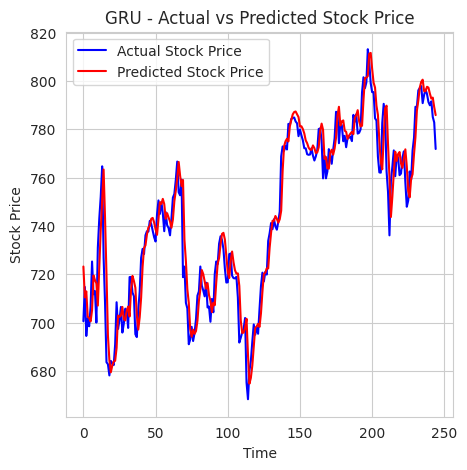

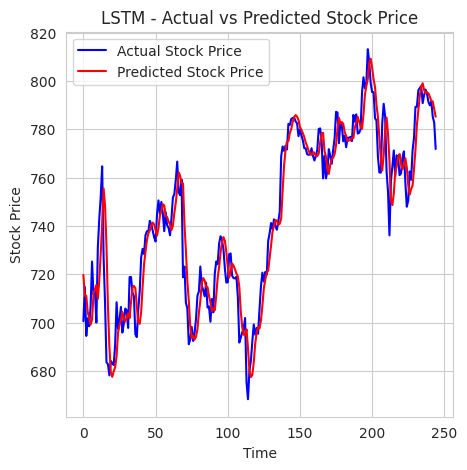

In [48]:
# Plot Actual vs Predicted for each model
for model_name, result in results.items():
    plt.figure(figsize=(5,5))
    plt.plot(result['Actual'], label='Actual Stock Price', color='blue')
    plt.plot(result['Predicted'], label='Predicted Stock Price', color='red')
    plt.title(f'{model_name} - Actual vs Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


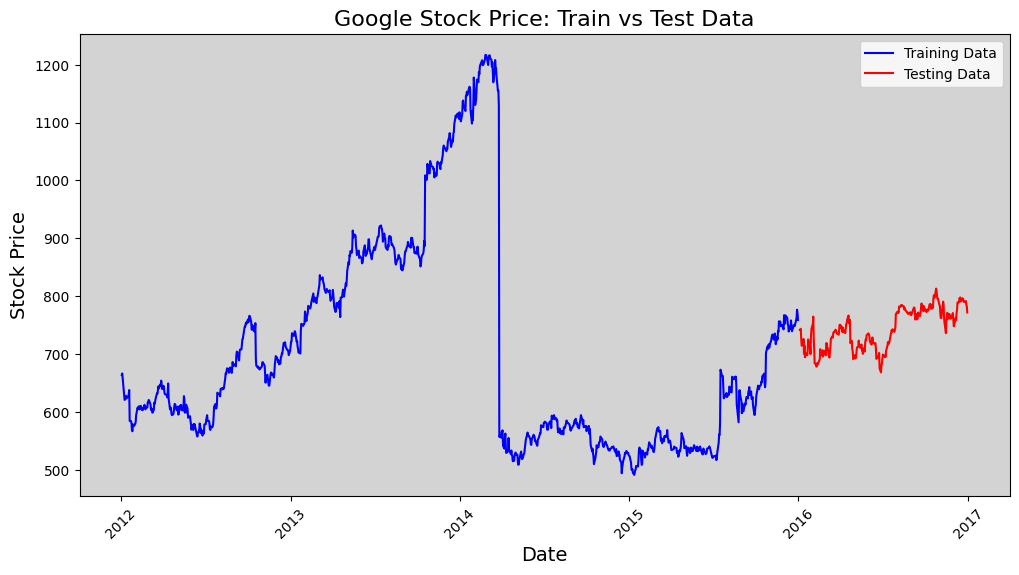

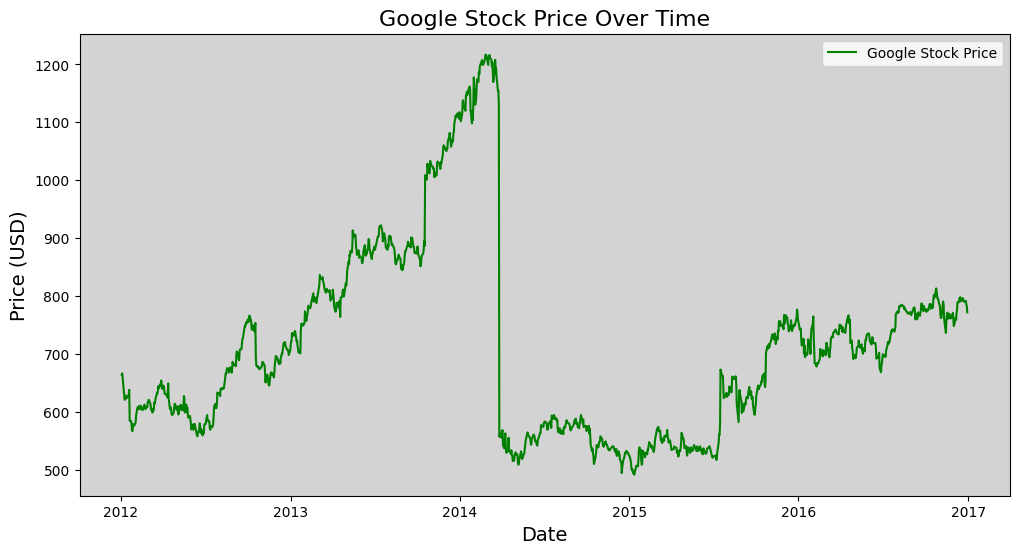

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('Google_Stock_Price_Train.csv')

# Remove commas from the 'Close' column and convert to float
data['Close'] = data['Close'].replace({',': ''}, regex=True).astype(float)

# Ensure 'Date' is in datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Split the dataset into training and testing datasets (80% train, 20% test)
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]

# Plot Date vs Close for training data and testing data
plt.figure(figsize=(12, 6))

# Plot for Training Data
plt.plot(train_data.index, train_data['Close'], label='Training Data', color='blue')

# Plot for Testing Data
plt.plot(test_data.index, test_data['Close'], label='Testing Data', color='red')

# Add labels and title
plt.title('Google Stock Price: Train vs Test Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Stock Price', fontsize=14)
plt.legend(loc='best')
plt.xticks(rotation=45)

# Set the background color to light grey
plt.gca().set_facecolor('lightgrey')

# Show the plot
plt.show()

# Plot the entire dataset for understanding the trend
plt.figure(figsize=(12, 6))

# Plot Closing Price for the entire dataset
plt.plot(data['Close'], label='Google Stock Price', color='green')

# Add labels and title
plt.title('Google Stock Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend()

# Set the background color to light grey
plt.gca().set_facecolor('lightgrey')

# Show the plot
plt.show()
